# LSTM scaling
After successfully optimizing a LSTM based neural network to predict wildfire risk in one California geopsatial bin, the next step is scale the model to make predictions for all 410 geospatial bins. A parallel LSTM architecture will be employed. Each of the 410 geospatial bins in California will get it's own input layer and LSTM layer, these will then be concatenated via a merge layer. The model output will be a 410 member vector where each element represents the prediction for one of the original geospatial bins.

### Goal: 
Scale LSTM neural network to make predictions for all 410 geospatial bins in California. Save trained model weights and optimized hyperparameters for deployment.

### Plan:
1. Prep data from one geospatial bin for input into LSTM
2. Build parallel LSTM model
3. Using hyperparameters from the single LSTM model as a starting point, tune and evaluate the parallel LSTM model.
4. Save trained model weights and hyperparameters for model deployment

# Notebook setup

In [1]:
import os
import sys
import logging
import tensorflow as tf

# Note: tf 2.1.0 give warning about model weight format when
# using class weights. This is the only way to silence without
# updating
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import pandas as pd
import tensorflow as tf
import sklearn as sk
from pickle import dump

from tensorflow import keras
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.client import device_lib

# Note: sklearn forces depreciation warnings
# This is the only way to silence them without updating
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

import helper_functions.plotting_functions as plotting_functions
import helper_functions.data_functions as data_functions
import helper_functions.config as config

print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sk.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.2.0
Keras 2.3.0-tf
SciKit Learn 0.23.1

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


In [2]:
# load configuration variables
data_file = '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox.parquet'

# 1. Data preparation

In [3]:
# read data and grab features of intrest
raw_data = pd.read_parquet(data_file)

raw_data.drop([
    'lat',
    'lon',
    'total_fires',
    'veg',
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'
    
], inplace=True, axis=1)

# make sure data is sorted by date
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data = raw_data.set_index('date')
raw_data = raw_data.sort_index()
raw_data.reset_index(inplace=True)

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 22 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date               datetime64[ns]
 1   apcp               float32       
 2   crain              int32         
 3   ignition           int32         
 4   mean_air_2m        float32       
 5   mean_rhum_2m       float32       
 6   mean_dpt_2m        float32       
 7   mean_pres_sfc      float32       
 8   mean_uwnd_10m      float32       
 9   mean_vwnd_10m      float32       
 10  mean_vis           float32       
 11  mean_cloud_cover   float32       
 12  raw_lat            float32       
 13  raw_lon            float32       
 14  range_air_2m       float32       
 15  range_rhum_2m      float32       
 16  range_dpt_2m       float32       
 17  range_pres_sfc     float32       
 18  range_uwnd_10m     float32       
 19  range_vwnd_10m     float32       
 20  range_vis          float

In [4]:
class_0_weight = ()
class_1_weight = ()
bins = raw_data.groupby(['raw_lat', 'raw_lon'])

for name, spatial_bin in bins:
    fires = spatial_bin['ignition'].sum()
    
    if fires == 0:
        class_0_weight = class_0_weight + (1,)
        class_1_weight = class_1_weight + (1,)
    
    else:
        observations = len(spatial_bin)
        class_0_weight = class_0_weight + (((1 / (observations - fires))*(observations)/2.0),)
        class_1_weight = class_1_weight + (((1 / fires)*(observations)/2.0),)

### Split data into training, validation and testing sets
Note: since temporal order matters here, we cannot simply randomly sample the data - we need to preserve the order. One possible improvement could be to break the data into many smaller ordered chunks and then sample those randomly...

In [5]:
# Split data up into training, testing and validation sets
testing_data = raw_data.tail(int(len(raw_data) * 0.1))
leftover_data = raw_data.head(int(len(raw_data) * 0.9))
validation_data = raw_data.tail(int(len(leftover_data) * 0.5))
training_data = raw_data.head(int(len(leftover_data) * 0.5))

Let's compare the distributions of each weather variable across the train, validation and test sets just to be sure that our samples are matched to a first approximation.

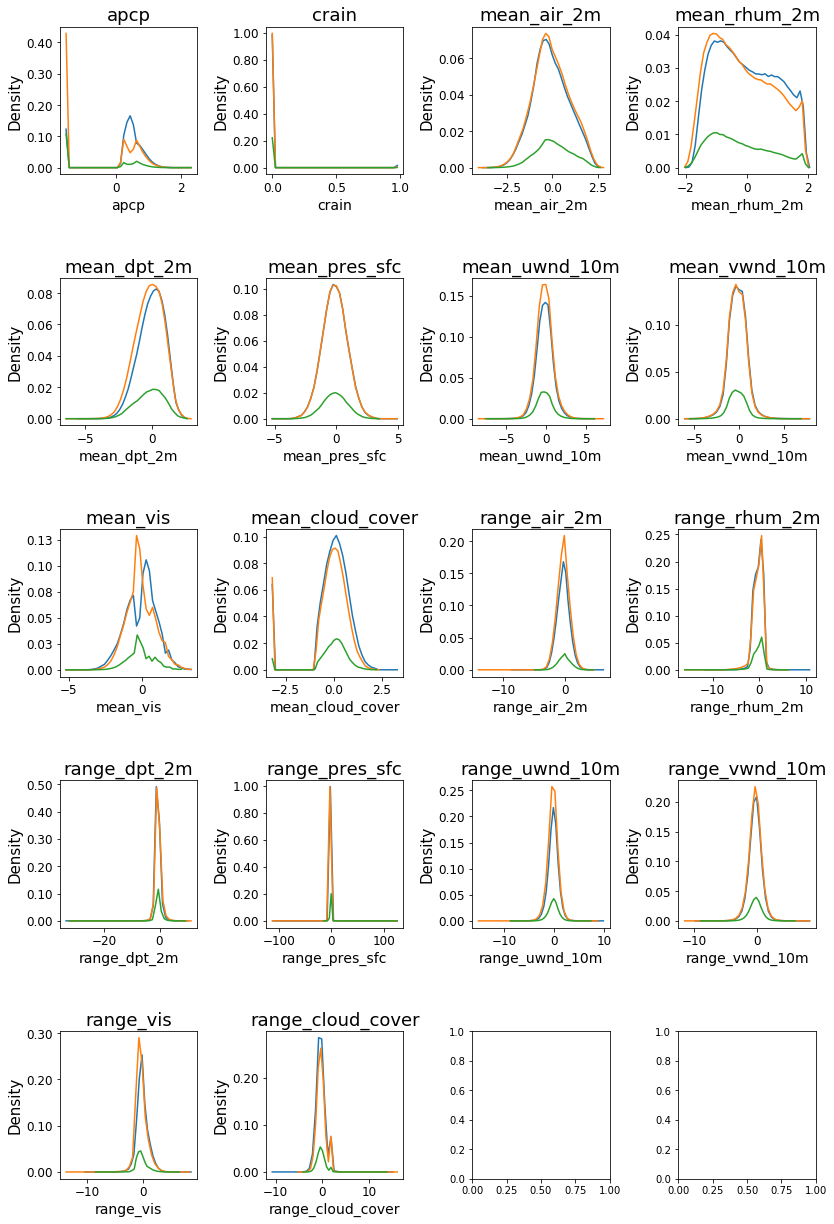

In [6]:
# plot split data distributions
features = [
    'apcp',
    'crain',
#     'veg',
    'mean_air_2m',       
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
    'mean_vis', 
    'mean_cloud_cover',
    'range_air_2m',
    'range_rhum_2m', 
    'range_dpt_2m',
    'range_pres_sfc',
    'range_uwnd_10m',
    'range_vwnd_10m',
    'range_vis',
    'range_cloud_cover'
]

left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 5
fig_cols = 4
plot_height = 20
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3),
    (4,0),(4,1),(4,2),(4,3)
]

xlabels = features
ylabels = ['Density'] * len(features)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features)):
    ax[plot_locations[i]] = plotting_functions.three_sample_density_plot(
        ax,
        plot_locations[i], 
        training_data, 
        validation_data, 
        testing_data, 
        features[i], 
        features[i], 
        features[i], 
        ylabels[i]
    )
    
plt.show()

### Format data for parallel LSTM
This part is a bit tricky - we need to form our data into samples, each sample containing 5 days of past history. Then we need a sequence of samples which spans the data set for each geospatial bin. Therefore, our input data will be a 410 member list of numpy arrays. The labels will be formated such that the first dimension is time and each time step contains a 410 member vector, one element for each of the 410 bins we are making predictions for.

In [7]:
num_fires = raw_data['ignition'].sum()
total_observations = len(raw_data)

print("Fires observed: {}".format(num_fires))
print("Total observations: {}".format(total_observations))
print()
print("Training data: {} observations".format(len(training_data)))
print("Validation data: {} observations".format(len(validation_data)))
print("Testing data: {} observations".format(len(testing_data)))

Fires observed: 124176
Total observations: 3594060

Training data: 1617327 observations
Validation data: 1617327 observations
Testing data: 359406 observations


In [8]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617327 entries, 0 to 1617326
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   date               1617327 non-null  datetime64[ns]
 1   apcp               1617327 non-null  float32       
 2   crain              1617327 non-null  int32         
 3   ignition           1617327 non-null  int32         
 4   mean_air_2m        1617327 non-null  float32       
 5   mean_rhum_2m       1617327 non-null  float32       
 6   mean_dpt_2m        1617327 non-null  float32       
 7   mean_pres_sfc      1617327 non-null  float32       
 8   mean_uwnd_10m      1617327 non-null  float32       
 9   mean_vwnd_10m      1617327 non-null  float32       
 10  mean_vis           1617327 non-null  float32       
 11  mean_cloud_cover   1617327 non-null  float32       
 12  raw_lat            1617327 non-null  float32       
 13  raw_lon            1617327 

In [9]:
# Split data into 410 member lists, one element for each geospatial bin (and network input)
# each element of the list contains samples with a duration of past_history

past_history = 4
future_target = 1
step = 1

x_training, y_training, training_lats, training_lons, training_dates = data_functions.format_features_labels_for_LSTM(
    training_data,        # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_validation, y_validation, validation_lats, validation_lons, validation_dates = data_functions.format_features_labels_for_LSTM(
    validation_data,      # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_testing, y_testing, testing_lats, testing_lons, testing_dates = data_functions.format_features_labels_for_LSTM(
    testing_data,         # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

In [10]:
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print()
print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
print()
print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))

x_training is <class 'list'>, length: 410, member shape: (3940, 4, 18).
y_training is <class 'list'>, length: 410, member shape: (3940,).

x_validation is <class 'list'>, length: 410, member shape: (3940, 4, 18).
y_validation is <class 'list'>, length: 410, member shape: (3940,).

x_testing is <class 'list'>, length: 410, member shape: (871, 4, 18).
y_testing is <class 'list'>, length: 410, member shape: (871,).


In [11]:
x_training, y_training = data_functions.trim_and_reshape_for_LSTM(x_training, y_training)
x_validation, y_validation = data_functions.trim_and_reshape_for_LSTM(x_validation, y_validation)
x_testing, y_testing = data_functions.trim_and_reshape_for_LSTM(x_testing, y_testing)

In [12]:
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print()
print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
print()
print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))

x_training is <class 'list'>, length: 410, member shape: (3939, 4, 18).
y_training is <class 'list'>, length: 3939, member shape: (410,).

x_validation is <class 'list'>, length: 410, member shape: (3939, 4, 18).
y_validation is <class 'list'>, length: 3939, member shape: (410,).

x_testing is <class 'list'>, length: 410, member shape: (871, 4, 18).
y_testing is <class 'list'>, length: 871, member shape: (410,).


In [13]:
# Trim each sample again to be a multiple of the batch size so we
# can do minibatch gradient descent - Note: this is required for statefull LSTMs

BATCH_SIZE = 2 * past_history

for i in range(len(x_training)):
    start_index = (x_training[i].shape[0] - (x_training[i].shape[0] % BATCH_SIZE))
    end_index = x_training[i].shape[0]

    x_training[i] = np.delete(x_training[i], range(start_index, end_index), axis=0)

y_training = np.delete(y_training, range(start_index, end_index), axis=0)

for i in range(len(x_validation)):
    start_index = (x_validation[i].shape[0] - (x_validation[i].shape[0] % BATCH_SIZE))
    end_index = x_validation[i].shape[0]

    x_validation[i] = np.delete(x_validation[i], range(start_index, end_index), axis=0)

y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

for i in range(len(x_testing)):
    start_index = (x_testing[i].shape[0] - (x_testing[i].shape[0] % BATCH_SIZE))
    end_index = x_testing[i].shape[0]

    x_testing[i] = np.delete(x_testing[i], range(start_index, end_index), axis=0)

y_testing = np.delete(y_testing, range(start_index, end_index), axis=0)

In [14]:
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print()
print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
print()
print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))

x_training is <class 'list'>, length: 410, member shape: (3936, 4, 18).
y_training is <class 'numpy.ndarray'>, length: 3936, member shape: (410,).

x_validation is <class 'list'>, length: 410, member shape: (3936, 4, 18).
y_validation is <class 'numpy.ndarray'>, length: 3936, member shape: (410,).

x_testing is <class 'list'>, length: 410, member shape: (864, 4, 18).
y_testing is <class 'numpy.ndarray'>, length: 864, member shape: (410,).


# 2. Build parallel LSTM model
The general model architecture is as follows - 410 input layers, one for each geospatial bin. Each input feeds into it's own LSTM layer. The LSTM layers are then concatenated and make there way through a number of fully connected layers and finally to a 410 member sigmoid activated output.

The loss function used is weighted binary cross-entropy. As this is a multilabel classification, not a multiclass classification softmax and categorical cross-entropy are not good choices because we can have more than one positive output amount the 410 for each time step.

In [15]:
# hyperparameters (adapted from single LSTM Cassandra model)
learning_rate = 0.0005
parallel_lstm_units = 5
# hidden_units = 100
# hidden_l2_lambda = 0.1
variational_dropout = 0.3

raw_output_bias = np.log([num_fires/(total_observations - num_fires)])[0]
output_bias = tf.keras.initializers.Constant(raw_output_bias)

metrics = [
    keras.metrics.TruePositives(name='true_positives'),
    keras.metrics.FalsePositives(name='false_positives'),
    keras.metrics.TrueNegatives(name='true_negatives'),
    keras.metrics.FalseNegatives(name='false_negatives'), 
    keras.metrics.AUC(name='AUC'),
    data_functions.matthews_correlation,
    data_functions.f1
]

In [16]:
inputs = []
LSTMs = []
fully_connected_layers = []

# make list of inputs, one for each geospatial bin
for i in range(len(x_training)):
    inputs.append(
        keras.Input(
            batch_shape=(
                BATCH_SIZE,
                x_training[0].shape[1],
                x_training[0].shape[2]
            )
        )
    )
    
# make list of LSTM layers, one for each geospatial bin
for i in range(len(x_training)):
    LSTMs.append(keras.layers.LSTM(
        parallel_lstm_units,
        dropout=variational_dropout#,
        #stateful = True
    )(inputs[i]))
    
# merge LSTM layers with concat layer
merged = keras.layers.concatenate(LSTMs)

# dense = keras.layers.Dense(
#     hidden_units,
#     bias_initializer=keras.initializers.VarianceScaling(
#         scale=1.0,
#         mode='fan_in', 
#         distribution='normal', 
#         seed=42
#     ),
#     kernel_regularizer=keras.regularizers.l2(hidden_l2_lambda),
#     activation = 'relu'
# )(merged)

# output layer
output = keras.layers.Dense(
    len(x_training),
    activation = 'sigmoid',
    bias_initializer = output_bias
)(merged)

# compile model
model = keras.Model(inputs=inputs, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr = learning_rate),
    loss = data_functions.weighted_bce(class_0_weight, class_1_weight),
    metrics = metrics
)

#print(model.summary())

# 2. Train and evaluate parallel LSTM model
The general model architecture is as follows - 410 input layers, one for each geospatial bin. Each input feeds into it's own LSTM layer. The LSTM layers are then concatenated and make their way through a number of fully connected layers and finally to a 410 member sigmoid activated output.

The loss function used is weighted binary cross-entropy. As this is a multilabel classification, not a multiclass classification softmax and categorical cross-entropy are not good choices because we can have more than one positive output among the 410 for each time step.

In [17]:
%%time

STEPS_PER_EPOCH = (x_training[0].shape[0] * 1) // BATCH_SIZE
VALIDATION_STEPS = (x_validation[0].shape[0] * 1) // BATCH_SIZE

history = model.fit(
    x_training, 
    y_training,
    batch_size = BATCH_SIZE, 
    epochs = 10,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_steps = VALIDATION_STEPS,
    validation_data = (x_validation, y_validation)
)

Epoch 1/10
492/492 [==============================] - 622s 1s/step - loss: 1.0760 - true_positives: 38438.0000 - false_positives: 464569.0000 - true_negatives: 1091811.0000 - false_negatives: 18942.0000 - AUC: 0.7461 - matthews_correlation: 0.1404 - f1: 0.0688 - val_loss: 1.0684 - val_true_positives: 46591.0000 - val_false_positives: 1002564.0000 - val_true_negatives: 554914.0000 - val_false_negatives: 9691.0000 - val_AUC: 0.6028 - val_matthews_correlation: 0.0276 - val_f1: 0.0493
Epoch 2/10
492/492 [==============================] - 485s 985ms/step - loss: 0.7196 - true_positives: 44074.0000 - false_positives: 538778.0000 - true_negatives: 1017602.0000 - false_negatives: 13306.0000 - AUC: 0.7715 - matthews_correlation: 0.1548 - f1: 0.0863 - val_loss: 0.9713 - val_true_positives: 46991.0000 - val_false_positives: 931753.0000 - val_true_negatives: 625725.0000 - val_false_negatives: 9291.0000 - val_AUC: 0.6206 - val_matthews_correlation: 0.0361 - val_f1: 0.0500
Epoch 3/10
492/492 [======

Total observations: 1617327


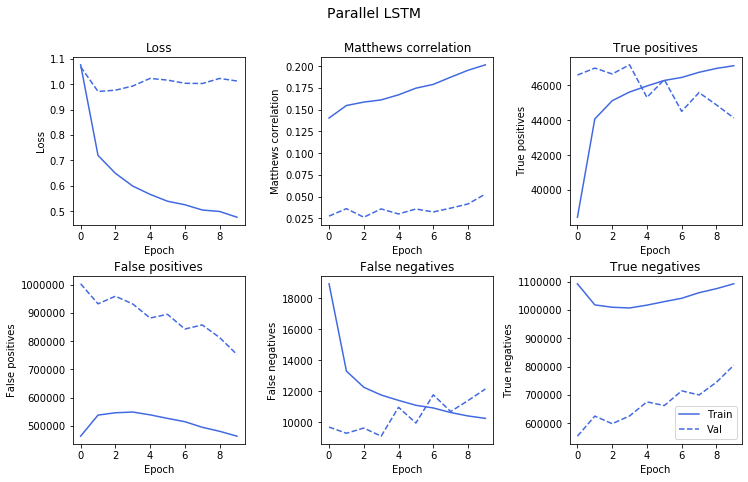

In [18]:
# plot learning curves
metric_names =  [
    'loss', 
    'matthews_correlation', 
    'true_positives', 
    'false_positives', 
    'false_negatives', 
    'true_negatives'
]

filename = '../project_info/figures/parallel_LSTM_learning_curves.png'
print(f"Total observations: {len(training_data)}")

plotting_functions.plot_metrics('Parallel LSTM', history, metric_names, filename)

In [19]:
training_predictions = model.predict(x_training, batch_size=BATCH_SIZE)
training_ignition_risk_predictions = training_predictions.flatten()
training_true_fires = y_training.flatten()

testing_predictions = model.predict(x_testing, batch_size=BATCH_SIZE)
testing_ignition_risk_predictions = testing_predictions.flatten()
testing_true_fires = y_testing.flatten()

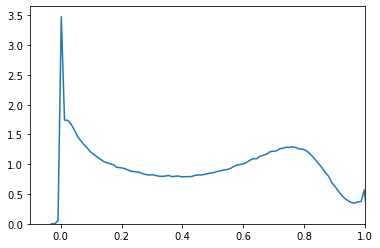

In [20]:
sns.kdeplot(training_ignition_risk_predictions, cumulative=False, bw=0.01)
plt.xlim(-0.1, 1)
plt.show()

In [21]:
training_results = model.evaluate(
    x_training,
    y_training,
    batch_size=BATCH_SIZE
)

testing_results = model.evaluate(
    x_testing,
    y_testing, 
    batch_size=BATCH_SIZE
)


Training data prediction results
No fire (True Negatives):  844110
False alarms (False Positives):  712270
Fires missed (False Negatives):  4867
Fires detected (True Positives):  52513
Total fires:  57380

Test data prediction results
No fire (True Negatives):  166752
False alarms (False Positives):  175635
Fires missed (False Negatives):  2754
Fires detected (True Positives):  9099
Total fires:  11853


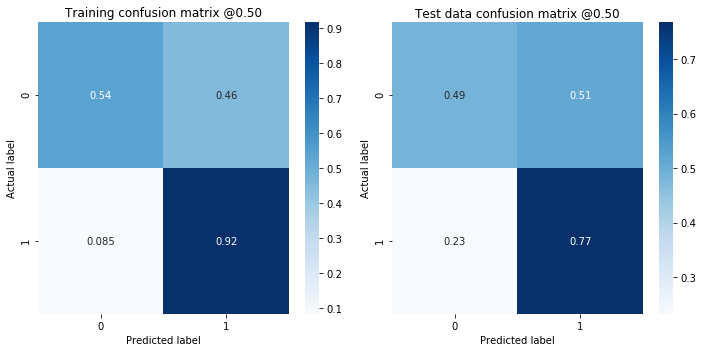

In [22]:
filename ='../project_info/figures/parallel_LSTM_confusion_matricies.png'  
plotting_functions.plot_cm(training_true_fires, training_ignition_risk_predictions, testing_true_fires, testing_ignition_risk_predictions, filename)

In [23]:
trimmed_training_dates = training_dates[:training_predictions.shape[0]]

formatted_predictions = pd.DataFrame(columns=['date', 'lat', 'lon', 'prediction'])

for prediction, date in zip(training_predictions, trimmed_training_dates):
    df = pd.DataFrame(list(zip(training_lats, training_lons, prediction)), 
               columns =['lat', 'lon', 'prediction'])
    
    df['date'] = date
    
    formatted_predictions = formatted_predictions.append(df)
    
formatted_predictions.head()

,date,lat,lon,prediction
0,1992-01-01,32.683891,-117.180901,0.126331
1,1992-01-01,32.721279,-116.851196,0.227561
2,1992-01-01,32.757439,-116.521004,0.521644
3,1992-01-01,32.792389,-116.190498,0.351412
4,1992-01-01,32.826099,-115.859596,0.251968


Worried that trimming the dates list is deforming the data. Implicit assumption is that the difference in lengths between the full date list and the first dimension of the predictions array is all at the end. May not be true. Need a better way to flatten and reassemble the geospatial time bins from LSTM input format.

In [24]:
formatted_predictions.tail()

,date,lat,lon,prediction
405,2002-10-10,41.859089,-122.052498,0.579113
406,2002-10-10,41.898472,-123.652901,0.283344
407,2002-10-10,41.916180,-121.671700,0.461071
408,2002-10-10,41.961609,-123.273499,0.733133
409,2002-10-10,41.971821,-121.290199,0.443874


In [25]:
states_shapefile = '../training_data_pipeline/data/spatial_data/cb_2018_us_state_500k.shp'
california = data_functions.get_california_polygon(states_shapefile)
multipoly = california.loc[16, 'geometry']
california_land_mass = multipoly[-1]

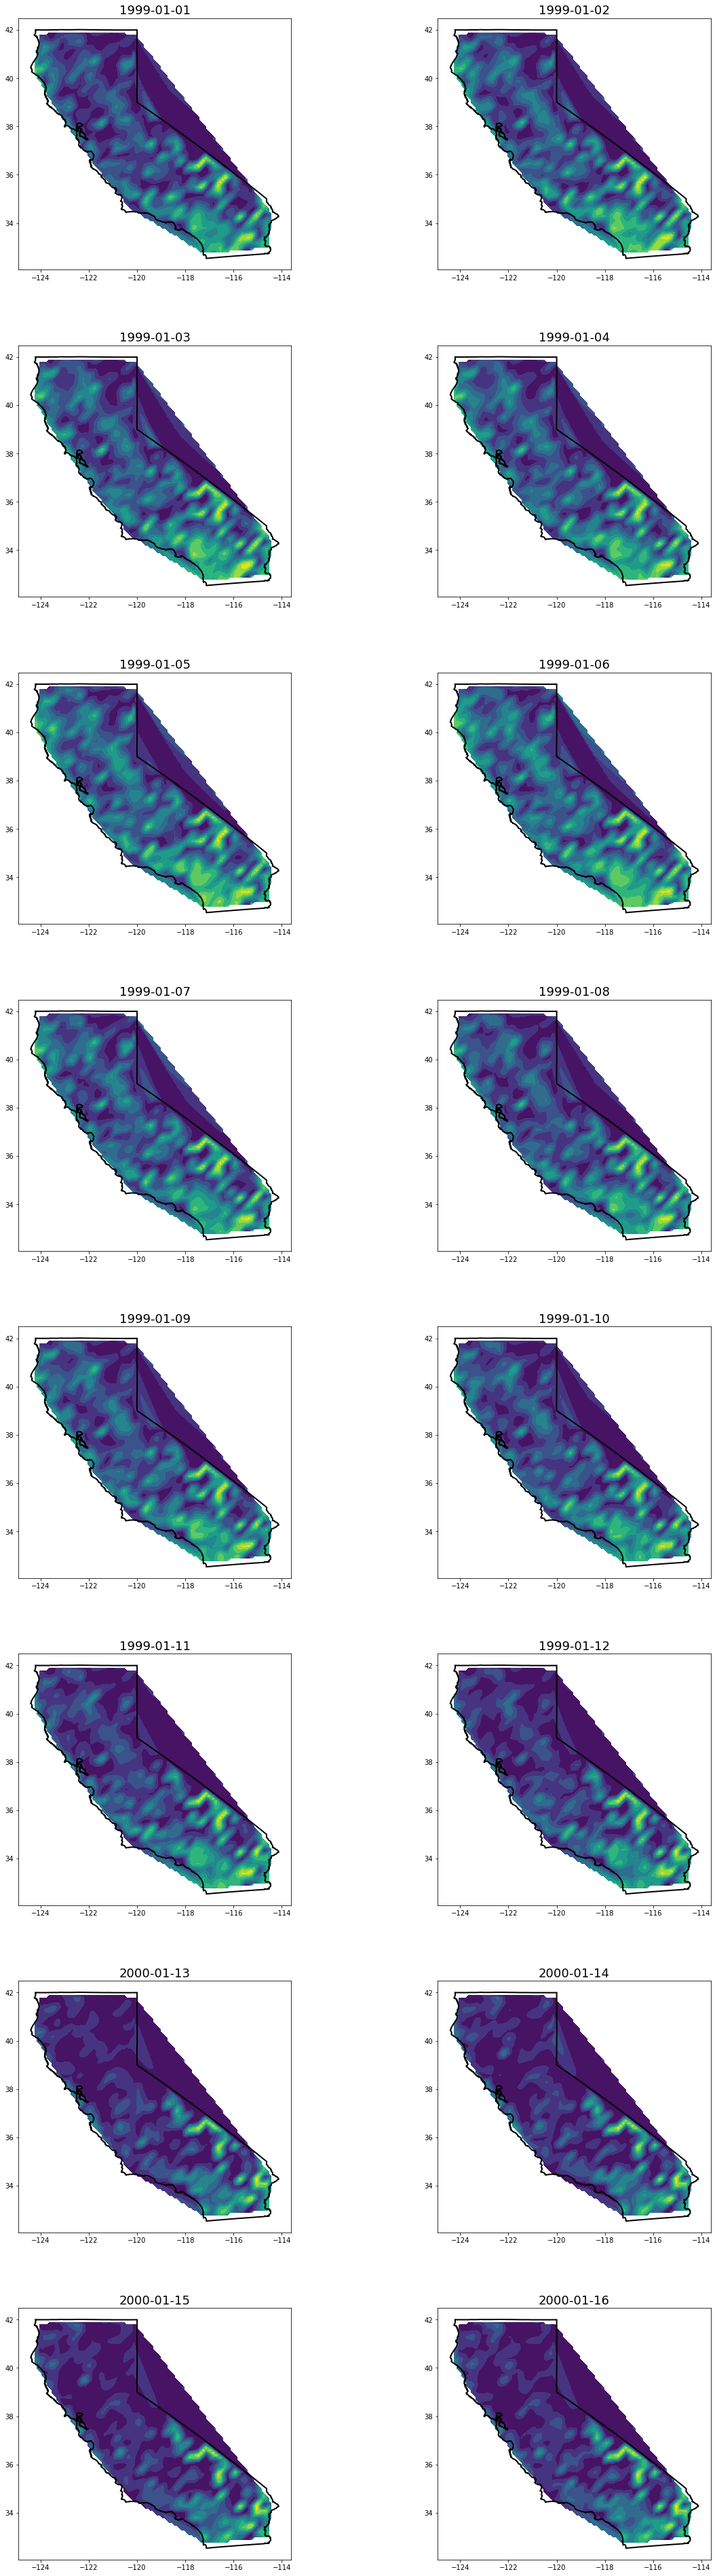

In [26]:
from descartes import PolygonPatch

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

fig_rows = 8
fig_cols = 2
plot_height = 65
plot_width = 30

plot_locations = [
    (0,0),(0,1),
    (1,0),(1,1),
    (2,0),(2,1),
    (3,0),(3,1),
    (4,0),(4,1),
    (5,0),(5,1),
    (6,0),(6,1),
    (7,0),(7,1)
]

# date_list = [
#     '1999-01-01',
#     '1999-02-01',
#     '1999-03-01',
#     '1999-04-01',
#     '1999-05-01',
#     '1999-06-01',
#     '1999-07-01',
#     '1999-08-01',
#     '1999-09-01',
#     '1999-10-01',
#     '1999-11-01',
#     '1999-12-01',
#     '2000-01-01',
#     '2000-02-01',
#     '2000-03-01',
#     '2000-04-01'
    
# ]

date_list = [
    '1999-01-01',
    '1999-01-02',
    '1999-01-03',
    '1999-01-04',
    '1999-01-05',
    '1999-01-06',
    '1999-01-07',
    '1999-01-08',
    '1999-01-09',
    '1999-01-10',
    '1999-01-11',
    '1999-01-12',
    '2000-01-13',
    '2000-01-14',
    '2000-01-15',
    '2000-01-16'  
]

num_contour_levels = 10

# formatted_predictions['lat'] = formatted_predictions['lat'].astype('float32')
# formatted_predictions['lon'] = formatted_predictions['lon'].astype('float32')

# prediction_data_by_day = formatted_predictions.groupby('date')

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

i = 0

while i < 16:
    date = str(date_list[i])
    predictions = formatted_predictions[formatted_predictions['date'] == date]
    predictions.drop('date', axis=1, inplace=True)

    xi, yi, zi = data_functions.regularize_grid(predictions, 'prediction', 0.1)

    ax[plot_locations[i]].add_patch(PolygonPatch(california_land_mass, fc='none', ec='black', lw='2', zorder=2))
    ax[plot_locations[i]].contourf(xi, yi, zi, num_contour_levels, cmap='viridis')
    ax[plot_locations[i]].set_title(date, fontsize=18)
    ax[plot_locations[i]].set_aspect('equal', adjustable='box')
    
    i += 1

# 4. Save model for deployment

In [27]:
# save trained weights
model.save_weights('./trained_model_weights/parallel_LSTM_weights.tf')

In [28]:
# # save model
# tf.saved_model.save(model, './trained_models/parallel_LSTM/')

Mock up some data to match what the live prediction data will look like to ensure the model works as expected after round tripping the weights.

In [29]:
# past_history = 5
# future_target = 1
# step = 1
# BATCH_SIZE = 1

# x_training, y_training = data_functions.format_features_labels_for_LSTM(
#     training_data,        # incomming_data
#     past_history,         # size of past history time chunk
#     future_target,        # number of future timepoints to predict from each history time chunk
#     step,                 # number of timepoints to move the history time chunk as we slide over the data
# )

# x_training, y_training = data_functions.trim_and_reshape_for_LSTM(x_training, y_training)

# for i in range(len(x_training)):
#     start_index = (x_training[i].shape[0] - (x_training[i].shape[0] % BATCH_SIZE))
#     end_index = x_training[i].shape[0]

#     x_training[i] = np.delete(x_training[i], range(start_index, end_index), axis=0)

In [30]:
# mock_data = []

# for spatial_bin in x_training:
#     bin_slice = spatial_bin[0:7,:,]
#     mock_data.append(bin_slice)
    
# mock_labels = y_training[0:7]
    
# print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
# print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
# print("mock_data is {}, length: {}, member shape: {}.".format(type(mock_data), len(mock_data), mock_data[0].shape))
# print("mock_labels are {}, length: {}, member shape: {}.".format(type(mock_labels), len(mock_labels), mock_labels[0].shape))

In [31]:
# inputs = []
# LSTMs = []

# for i in range(len(mock_data)):
#     inputs.append(
#         keras.Input(
#             batch_shape=(
#                 BATCH_SIZE,
#                 mock_data[0].shape[1],
#                 mock_data[0].shape[2]
#             )
#         )
#     )
    
# for i in range(len(mock_data)):
#     LSTMs.append(keras.layers.LSTM(
#         lstm_units,
#         dropout = variational_dropout,
#         stateful = True
#     )(inputs[i]))
    
# merged = keras.layers.concatenate(LSTMs)

# hidden1 = keras.layers.Dense(
#     hidden_units,
#     kernel_regularizer=keras.regularizers.l1(hidden_l1_lambda),
#     bias_initializer=tf.keras.initializers.he_normal(),
#     activation = 'relu'
# )(merged)

# hidden2 = keras.layers.Dense(
#     hidden_units,
#     kernel_regularizer=keras.regularizers.l1(hidden_l1_lambda),
#     bias_initializer=tf.keras.initializers.he_normal(),
#     activation = 'relu'
# )(hidden1)

# output = keras.layers.Dense(
#     410,
#     activation = 'sigmoid',
#     bias_initializer = output_bias
# )(hidden2)

# production_model = keras.Model(inputs=inputs, outputs=output)

# production_model.load_weights('./trained_model_weights/parallel_LSTM_weights.tf')
# production_model.summary()

In [32]:
# mock_predictions = production_model.predict(mock_data)
# flat_mock_predictions = mock_predictions.flatten()

In [33]:
# sns.kdeplot(flat_mock_predictions, cumulative=False, bw=0.01)
# plt.xlim(-0.1, 1)
# plt.show()